In [14]:
%matplotlib inline
import torch
import matplotlib
from torch import nn
from d2l import torch as d2l

首先，我们[**像以前一样生成一些数据**]，生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。

In [41]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train) 
    # synthetic_data Generate y = Xw + b + noise.
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [42]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### (**定义$L_2$ $L_1$范数惩罚**)

In [43]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [44]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

In [45]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr =100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:

            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch +1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是:', torch.norm(w).item())                                


### [**忽略正则化直接训练**]

我们现在用`lambd = 0`禁用权重衰减后运行这个代码。这里训练误差有了减少，但测试误差没有减少。

w的L2范数是: 36.33563232421875


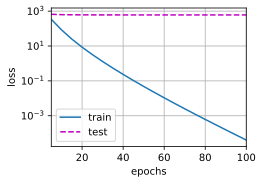

In [46]:
train(lambd=0)

w的L2范数是: 0.15665404498577118


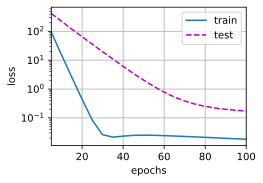

In [47]:
train(lambd=5)

## [**简洁实现**]

In [48]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003

    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    #神经网络优化器，主要是为了优化我们的神经网络，使他在我们的训练过程中快起来，节省社交网络训练的时间
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                        (d2l.evaluate_loss(net, train_iter, loss),
                        d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数:', net[0].weight.norm().item())

w的L2范数: 13.341995239257812


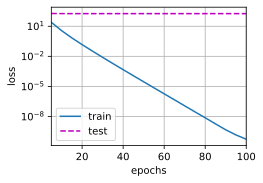

In [49]:
train_concise(0)

w的L2范数: 0.13204586505889893


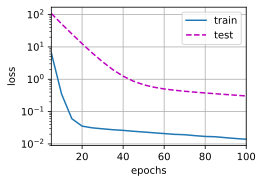

In [50]:
train_concise(6)